# Blurring Algorithms and Noise


In [21]:
from torchvision import transforms
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [22]:
# Load images
folder = 'Images/'
device = 'cpu'
image = 'pigeon.jpeg'

image_path = folder + image  # Replace with your image path
image = Image.open(image_path)
transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((256, 256)),
        transforms.ToTensor()  
    ])
img_tensor = transform(image).squeeze()  # Remove channel dimension

## Shot noise (poisson noise)
Occurs when there is a finite number of particles that carry energy, such as photons in an image sensor or electrons in a circuit. Shot noise is one of the main types of noise that degrade image quality. 

Shot noise follows a Poisson distribution because:

1. **Discrete countable events**: Each photon arrival is a discrete, countable event
2. **Constant Average Rate $\lambda$**: The average rate of photon arrivals depends on the light intensity (brighter = more photons per second)
3. **No simultaneous Events**: In any tiny time interval, the probability of a photon arriving is very small. In an infinitesimally small window the probability of more than one event occuring is $\approx 0$
4. **Independent**: Previous photon arrivals don't affect future arrivals

These conditions exactly match the assumptions of a Poisson process. The number of photons detected in a fixed time period ($\Delta t$) follows:

$$P(k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

Where:
- $k$ = number of photons detected
- $\lambda$ = average number of photons arriving in $\Delta t$ (proportional to light intensity)
- Higher $\lambda$ = brighter pixel = more photons = less relative noise 
- Lower $\lambda$ = darker pixel = fewer photons = more relative noise

This is why images taken in low light (few photons) are much noisier than images in bright light (many photons).

## Method
- The number of photons in each pixel was simulated depending on the brightness of the pixel and its scale factor.
- The photon count was set as the expected value $\lambda$ of the number of photons in the pixel
- `torch.poisson` randomly generates the number of photons present due to random variation


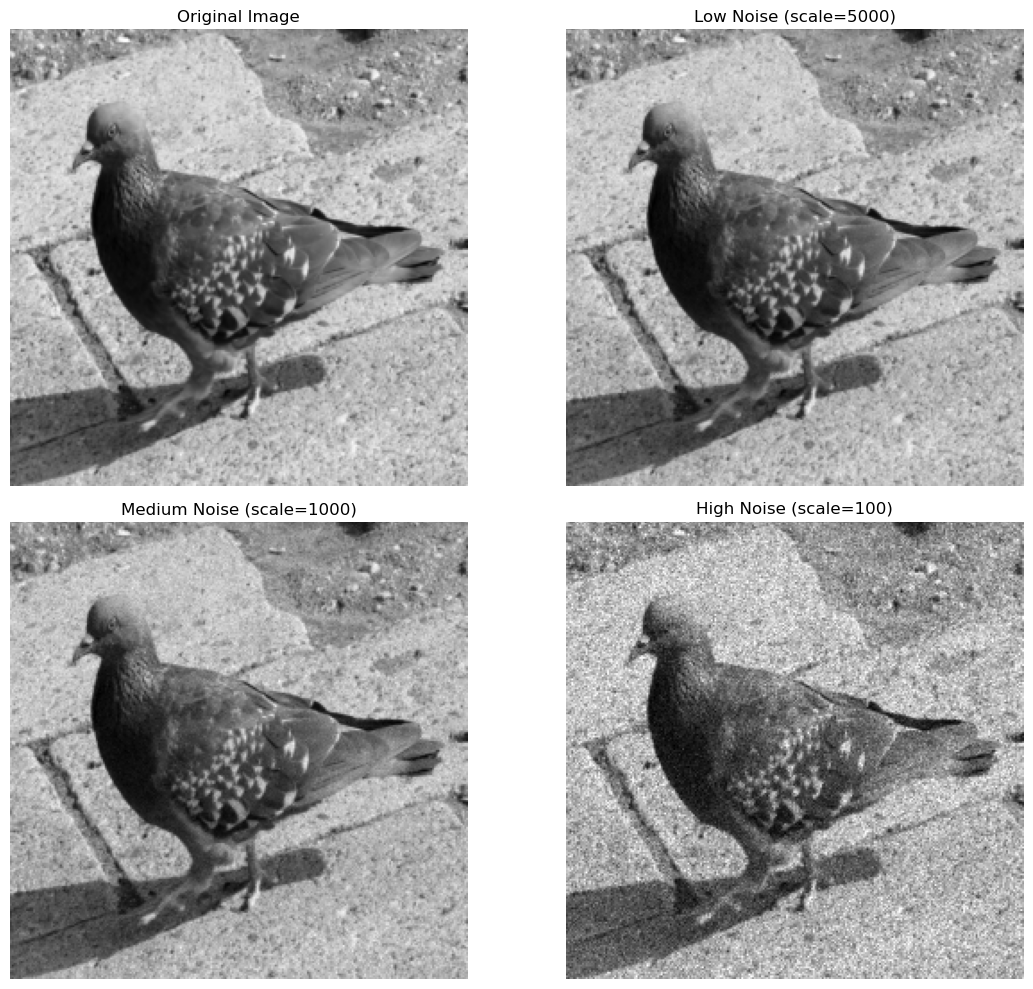

In [23]:
def add_poisson_noise(image, scale_factor=1000):
    """
    Add realistic Poisson (shot) noise to an image
    
    Args:
        image: Input tensor in range [0,1]
        scale_factor: Higher values = less noise (more photons)
    """
    # Convert to photon counts (scale up to simulate photon detection)
    photon_counts = image * scale_factor
    
    # Apply Poisson noise 
    noisy_photons = torch.poisson(photon_counts)
    
    # Convert back to [0,1] range
    noisy_image = noisy_photons / scale_factor
    
    return torch.clamp(noisy_image, 0, 1)

# Create noisy images with different noise levels
torch.manual_seed(42)  

# Low noise (high photon count)
noisy_low = add_poisson_noise(img_tensor, scale_factor=5000)

# Medium noise 
noisy_medium = add_poisson_noise(img_tensor, scale_factor=1000)

# High noise (low photon count - like low light)
noisy_high = add_poisson_noise(img_tensor, scale_factor=100)

# Display results
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0,0].imshow(img_tensor, cmap='gray')
ax[0,0].set_title('Original Image')
ax[0,0].axis('off')

ax[0,1].imshow(noisy_low, cmap='gray')
ax[0,1].set_title('Low Noise (scale=5000)')
ax[0,1].axis('off')

ax[1,0].imshow(noisy_medium, cmap='gray')
ax[1,0].set_title('Medium Noise (scale=1000)')
ax[1,0].axis('off')

ax[1,1].imshow(noisy_high, cmap='gray')
ax[1,1].set_title('High Noise (scale=100)')
ax[1,1].axis('off')

plt.tight_layout()
plt.show()

## The box filter
The box filter is a type of low pass filter which helps to remove noise and blurs images. A convolution kernel is a matrix which each position in the image is multiplied by. The box filter uses the box function as the convolution kernel. The convolution kernel for the box filter is the box function given as:

$$\text{box}_{N,M}(n,m) = \begin{cases} 
1 & \text{if} -N \leq n \leq N \text{and} - M \leq m \leq M \\
0 & \text{else}
\end{cases}$$

The blured of each pixel is the average of the surrounding pixels given as:

$$p'_{x,y} = \frac{\sum^{\text{all}}_{x,y} \text{box}_{N,M}(n,m) p_{x,y}}{\sum^{\text{all}}_{x,y} \text{box}_{N,M}(n,m)}$$

In [24]:
import torch.nn.functional as F

def box_function(X, Y, N, M):
    box = torch.zeros_like((X,Y))
    box[torch.abs(X) <= N/2] = 1
    box[torch.abs(Y) <= M/2] = 1
    return box

def box_filter_fast(image, N, M):
    """
    Fast box filter implementation using PyTorch convolution
    
    Args:
        image: 2D tensor [H, W] in range [0,1]
        kernel_size: Size of the box filter (odd number recommended)
    
    Returns:
        Filtered image tensor [H, W]
    """
    # Create box kernel (uniform averaging)
    kernel = torch.ones(1, 1, N, M) / (N * M)
    
    # Add batch and channel dimensions: [H, W] -> [1, 1, H, W]
    image_4d = image.unsqueeze(0).unsqueeze(0)
    
    # Apply convolution with padding to maintain image size
    padding = (N // 2, M // 2)
    filtered = F.conv2d(image_4d, kernel, padding=padding)
    
    # Remove batch and channel dimensions: [1, 1, H, W] -> [H, W]
    return filtered.squeeze(0).squeeze(0)




(np.float64(-0.5), np.float64(256.5), np.float64(255.5), np.float64(-0.5))

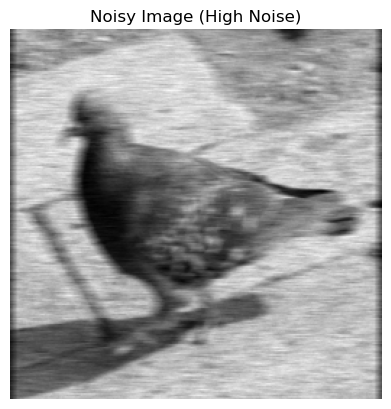

In [25]:
N = 1
M = 10
blur_up = box_filter_fast(noisy_high, N, M)
kernel = torch.ones(1, 1, N, M) / (N * M)
fig, ax = plt.subplots()
ax.imshow(blur_up, cmap='gray')
ax.set_title('Noisy Image (High Noise)')
ax.axis('off')

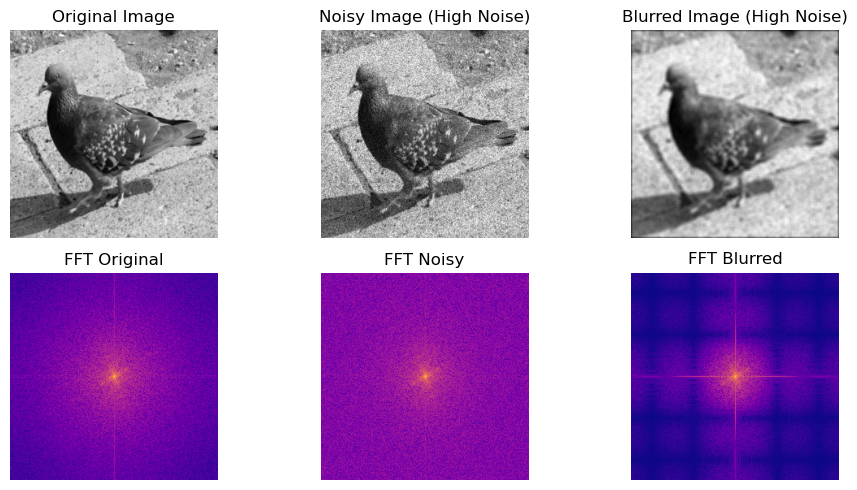

In [ ]:
blured_noisy_high = box_filter_fast(noisy_high, 5, 5)

# Compute fourier transforms for visualization
original_fft = torch.fft.fftshift(torch.fft.fft2(img_tensor))
noisy_fft = torch.fft.fftshift(torch.fft.fft2(noisy_high))
blurred_fft = torch.fft.fftshift(torch.fft.fft2(blured_noisy_high))

fig, ax = plt.subplots(2, 3, figsize=(10, 5))
ax[0,0].imshow(img_tensor, cmap='gray')
ax[0,0].set_title('Original Image')
ax[0,0].axis('off')

ax[0,1].imshow(noisy_high, cmap='gray')
ax[0,1].set_title('Noisy Image (High Noise)')
ax[0,1].axis('off')

ax[0,2].imshow(blured_noisy_high, cmap='gray')
ax[0,2].set_title('Blurred Image (High Noise)')
ax[0,2].axis('off')

ax[1,0].imshow(torch.log1p(torch.abs(original_fft)), cmap='plasma')
ax[1,0].set_title('FFT Original')
ax[1,0].axis('off')

ax[1,1].imshow(torch.log1p(torch.abs(noisy_fft)), cmap='plasma')
ax[1,1].set_title('FFT Noisy')
ax[1,1].axis('off')

ax[1,2].imshow(torch.log1p(torch.abs(blurred_fft)), cmap='plasma')
ax[1,2].set_title('FFT Blurred')
ax[1,2].axis('off')

fig.tight_layout()
#fowier convolution theorem, convolution theorem 3 blue 1 brown